In [25]:
import random as rd
import math

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time  # for default seed using time.clock()

In [4]:
def rand(seed=None):
    """
    Generate pseudo-random number in range [0, 1) (Uniformally-distributed)
    X_n+1 = (aX_n + c) % m
    """
    if not hasattr(rand, 'x'):
        rand.x = time.clock() if seed is None else seed
        rand.a = 15_485_863
        rand.c = 373_587_883
        rand.m = 573_268_139
    rand.x = ((rand.a * rand.x + rand.c) % rand.m) 
    return rand.x / rand.m

In [4]:
%load_ext Cython

In [5]:
%%cython
from libc.time cimport clock
cimport cython

cdef:
    double x_n = 0.0;
    double a = 15485863;
    double c = 373587883;
    double m = 573268139;

cpdef double rand_fast(double seed=0.0):
    global x_n, a, b, c;
    if x_n == 0.0 and seed == 0.0:
        x_n = <double>clock();
    x_n = (a * x_n + c) % m;
    return x_n / m;

In [158]:
data = [rand_fast() for _ in range(100_000_00)]

In [157]:
%%timeit
data = [rand() for _ in range(10_000)]

8.04 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [151]:
%%timeit
data = [rand_fast() for _ in range(10_000)]

1.51 ms ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


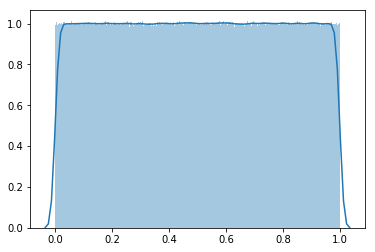

In [160]:
sns.distplot(np.array(data), bins=300);

In [7]:
def gauss(mu: float=0, sigma: float=1) -> float:
    """
    Generate sample ~ N(μ, σ^2)
    """
    if hasattr(gauss, 'z1'):
        z1 = gauss.z1
        del gauss.z1
        return z1 * sigma + mu
    u1, u2 = rand_fast(), rand_fast()
    z0 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    gauss.z1 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    # X = Z * σ + μ
    return z0 * sigma + mu

In [33]:
%%timeit
data = [gauss() for _ in range(10000)]

14.9 ms ± 90 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [144]:
%%timeit
data = [gauss() for _ in range(10000)]  # with my rand_fast()

12.3 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [145]:
data = [gauss() for _ in range(10_000_00)]

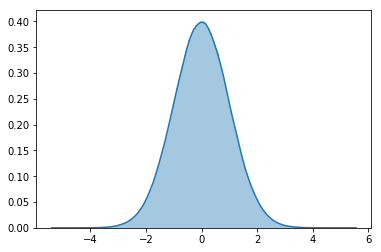

In [147]:
sns.distplot(np.array(data), bins=300);

In [8]:
%%cython
from libc.math cimport sqrt, log, sin, cos, M_PI
from libc.stdlib cimport rand
cimport cython

cdef extern from "limits.h":
    double RAND_MAX

cdef double two_pi = M_PI * 2;
cdef double z1_cache[1];

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.wraparound(False)
cpdef double gauss_fast(double mu=0, double sigma=1):
    global z1_cache
    cdef:
        double u1, u2, z0, r, k;
    
    if z1_cache[0] != 0:
        z1 = z1_cache[0];
        z1_cache[0] = 0.0;
        return z1;
    u1 = (<float>rand()) / RAND_MAX;
    u2 = (<float>rand()) / RAND_MAX;
    r = sqrt(-2 * log(u1));
    k = two_pi * u2;
    z0 = r * cos(k);
    z1_cache[0] = r * sin(k);    
    # X = Z * σ + μ
    return z0 * sigma + mu


UsageError: Cell magic `%%cython` not found.


In [12]:
%%timeit
data = [gauss_fast() for _ in range(10_000)]

1.12 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [84]:
%%timeit
data = [rd.gauss(0, 1) for _ in range(10_000)]

6.93 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
data = [gauss_fast() for _ in range(10_000_000)]

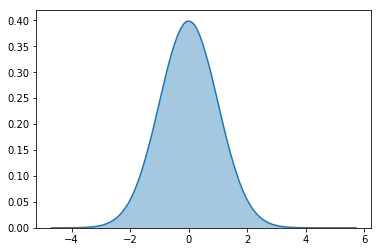

In [18]:
sns.distplot(np.array(data), bins=300);

In [161]:
a = np.array([[1, 2], [3, 4]])

In [162]:
vfunc = np.vectorize(lambda x: 1)

In [179]:
def arr_gauss(mu=0, sigma=1, size=1):
    return gauss_fast() if size == 1 else np.fromiter((gauss_fast(mu, sigma) for _ in range(size)), dtype=np.float64)

In [178]:
%%timeit
arr_gauss(size=10_000_0)

17.4 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
def uniform(low=0.0, high=1.0, size=None):
    n_samples = 1
    if size is not None:
        for i in size:
            n_samples *= i
    scale = high - low
    return [low + scale * rand() for _ in range(n_samples)]

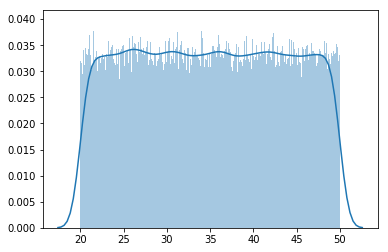

In [19]:
data = uniform(20, 50, (100000,))
sns.distplot(np.array(data), bins=300)

In [7]:
# exponential
def exponential(scale=1.0, size=None):
    """
    Draw samples from an exponential distribution.
    
    @param scale: inverse of the rate parameter
    @param size: if None, one sample is produced. Otherwise must be iterable.
                 For example (n, k, m) will produce n * k * m samples
    """
    n_samples = 1
    if size is not None:
        for i in size:
            n_samples *= i
    # Quantile function F^-1(p, λ) = -ln(1-p) / λ
    return [scale * -math.log(rand()) for _ in range(n_samples)]

In [1]:
%load_ext Cython

In [7]:
%%cython
from libc.math cimport sqrt, log, sin, cos, M_PI
from __main__ import *
from cpython cimport array
import array
cimport cython

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.wraparound(False)
cpdef array.array exponential_fast(double scale=1.0, size=None):
    cdef:
        unsigned int n_samples, i;
    n_samples = 1
    if size is not None:
        for i in size:
            n_samples *= i
    return array.array('d', [scale * -log(rand_fast()) for _ in range(n_samples)])

In [12]:
%%timeit
data = exponential_fast(20, size=(10000,))

1.3 ms ± 6.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%%timeit
data = exponential(20, (10000,))

9.48 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


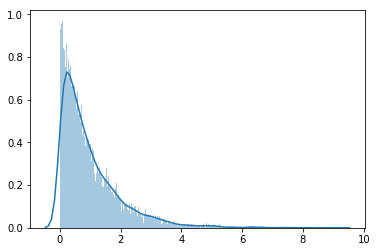

In [11]:
sns.distplot(np.array(data), bins=300)

In [9]:
def beta(alpha=1.0, beta=1.0):
    alpha = math.ceil(alpha)
    beta = math.ceil(beta)
    n_samples = alpha + beta - 1
    samples = sorted([rand() for _ in range(n_samples)])
    return samples[alpha - 1]

In [1]:
%load_ext Cython

In [33]:
%%cython
from libc.math cimport ceil
from __main__ import *

cpdef double beta_fast(double alpha=1.0, double beta=1.0):
    cdef:
        unsigned int n_samples, a, b;
    n_samples = <unsigned int>ceil(alpha + beta - 1)
    if n_samples == 1:
        return rand_fast()
    else:
        samples = sorted([rand_fast() for _ in range(n_samples)])
        return samples[ceil(alpha) - 1]

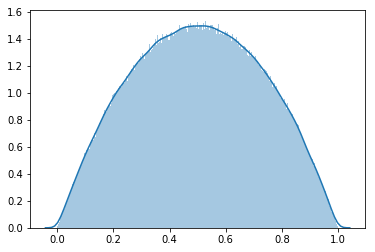

In [14]:
data = [beta(2, 2) for _ in range(1000000)]
sns.distplot(np.array(data), bins=300)

In [15]:
%%timeit
data = [beta(2, 2) for _ in range(10000)]

31.4 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
data = [beta_fast(2, 2) for _ in range(10000)]

4.91 ms ± 75.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
data = [beta_fast(.5, .9) for _ in range(100000)]

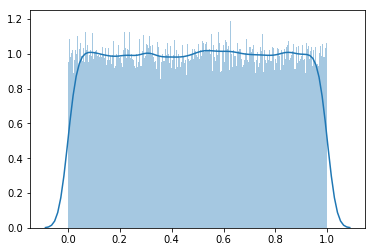

In [41]:
sns.distplot(np.array(data), bins=300)

In [149]:
def randint(low, high=None, seed=None):
    if high is None:
        high = low
        low = 0
    n = int(high - low + 1)
    if not hasattr(rand, 'x'):
        rand.x = int(time.clock()) if seed is None else seed
        rand.a = 15_485_863
        rand.c = 373_587_883
        rand.m = 573_268_139
    rand.x = ((rand.a * rand.x + rand.c) % rand.m)
    out = rand.x % n
    remainder = rand.m % n
    while rand.x >= rand.m - remainder:
        print("greater!")
        rand.x = ((rand.a * rand.x + rand.c) % rand.m)
        out = rand.x % n
    return low + out

In [162]:
%%cython
from libc.time cimport clock
cimport cython

cdef:
    double x_n = 0.0;
    double a = 15485863;
    double c = 373587883;
    double m = 573268139;

cpdef int randint_fast(int low, high=None, double seed=0.0):
    global x_n, a, b, c;
    cdef:
        int out, n;
    if high is None:
        high = low
        low = 0
    n = high - low + 1
    if x_n == 0.0 and seed == 0.0:
        x_n = <double>clock();
    x_n = (a * x_n + c) % m;
    return low + <int>x_n % n

In [176]:
data = [randint(20, 50) for _ in range(1000000)]

In [174]:
data = [randint_fast(20, 50) for _ in range(10000000)]

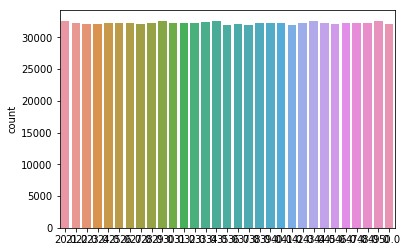

In [177]:
sns.countplot(np.array(data))

In [178]:
%%timeit
data = [randint(20, 50) for _ in range(10000)]

12 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [179]:
%%timeit
data = [randint_fast(20, 50) for _ in range(10000)]

1.76 ms ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
